# Data preparation

In [1]:
from google.colab import drive
drive.mount("/content/drive")
%cd './drive/MyDrive'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [2]:
import glob
import os
import re
import zipfile
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

import gdown
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')

In [3]:
# !wget https://drive.google.com/file/d/1dzM9AKtIQz6j0WpNeKBmLmJvLe33q1KQ/view?usp=share_link -O archive.zip

In [3]:
!unzip /content/drive/MyDrive/BooksRecSys/archive.zip -d BooksRecSys

Archive:  /content/drive/MyDrive/BooksRecSys/archive.zip
  inflating: BooksRecSys/book1-100k.csv  
  inflating: BooksRecSys/book1000k-1100k.csv  
  inflating: BooksRecSys/book100k-200k.csv  
  inflating: BooksRecSys/book1100k-1200k.csv  
  inflating: BooksRecSys/book1200k-1300k.csv  
  inflating: BooksRecSys/book1300k-1400k.csv  
  inflating: BooksRecSys/book1400k-1500k.csv  
  inflating: BooksRecSys/book1500k-1600k.csv  
  inflating: BooksRecSys/book1600k-1700k.csv  
  inflating: BooksRecSys/book1700k-1800k.csv  
  inflating: BooksRecSys/book1800k-1900k.csv  
  inflating: BooksRecSys/book1900k-2000k.csv  
  inflating: BooksRecSys/book2000k-3000k.csv  
  inflating: BooksRecSys/book200k-300k.csv  
  inflating: BooksRecSys/book3000k-4000k.csv  
  inflating: BooksRecSys/book300k-400k.csv  
  inflating: BooksRecSys/book4000k-5000k.csv  
  inflating: BooksRecSys/book400k-500k.csv  
  inflating: BooksRecSys/book500k-600k.csv  
  inflating: BooksRecSys/book600k-700k.csv  
  inflating: BooksRe

In [3]:
books = pd.concat(
    [
        pd.read_csv(str(x.resolve()))
        for x in Path("/content/drive/MyDrive/BooksRecSys").glob("*k.csv")
    ]
)
books.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1850310 entries, 0 to 40889
Data columns (total 21 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Id                     int64  
 1   Name                   object 
 2   RatingDist1            object 
 3   pagesNumber            float64
 4   RatingDist4            object 
 5   RatingDistTotal        object 
 6   PublishMonth           int64  
 7   PublishDay             int64  
 8   Publisher              object 
 9   CountsOfReview         int64  
 10  PublishYear            int64  
 11  Language               object 
 12  Authors                object 
 13  Rating                 float64
 14  RatingDist2            object 
 15  RatingDist5            object 
 16  ISBN                   object 
 17  RatingDist3            object 
 18  Description            object 
 19  Count of text reviews  float64
 20  PagesNumber            float64
dtypes: float64(4), int64(5), object(12)
memory usage: 310.6+

Let's remove the extra columns.

In [ ]:
books.drop(
    columns=["RatingDist1", "RatingDist2", "RatingDist3", "RatingDist4"], inplace=True
)

Each rating column looks like x: 432411, where x is the number of stars, since this spoils the data typing, we can remove it, turn the RatingDist columns into int by dividing the first part.

In [6]:
books["RatingDist5"] = books["RatingDist5"].str.split(":").str[1]
books["RatingDistTotal"] = books["RatingDistTotal"].str.split(":").str[1]

to_convert = ["RatingDist5", "RatingDistTotal"]
for col in to_convert:
    books[col] = books[col].astype(int)

books.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1850310 entries, 0 to 40889
Data columns (total 17 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Id                     int64  
 1   Name                   object 
 2   pagesNumber            float64
 3   RatingDistTotal        int64  
 4   PublishMonth           int64  
 5   PublishDay             int64  
 6   Publisher              object 
 7   CountsOfReview         int64  
 8   PublishYear            int64  
 9   Language               object 
 10  Authors                object 
 11  Rating                 float64
 12  RatingDist5            int64  
 13  ISBN                   object 
 14  Description            object 
 15  Count of text reviews  float64
 16  PagesNumber            float64
dtypes: float64(4), int64(7), object(6)
memory usage: 254.1+ MB


## Name

In [7]:
books["Name"].nunique()

1636235

Not all names are unique. There are probably books published under the same title but by different publishers.

In [8]:
# Droping duplicates
books.drop_duplicates(subset=["Name"], inplace=True)

In [9]:
books.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1636235 entries, 0 to 40889
Data columns (total 17 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Id                     1636235 non-null  int64  
 1   Name                   1636235 non-null  object 
 2   pagesNumber            718417 non-null   float64
 3   RatingDistTotal        1636235 non-null  int64  
 4   PublishMonth           1636235 non-null  int64  
 5   PublishDay             1636235 non-null  int64  
 6   Publisher              1619540 non-null  object 
 7   CountsOfReview         1636235 non-null  int64  
 8   PublishYear            1636235 non-null  int64  
 9   Language               206442 non-null   object 
 10  Authors                1636235 non-null  object 
 11  Rating                 1636235 non-null  float64
 12  RatingDist5            1636235 non-null  int64  
 13  ISBN                   1631248 non-null  object 
 14  Description         

## Authors

In [10]:
books["Authors"].nunique()

664316

There are 3 times fewer authors than books. Is it possible to say that on average 1 author writes or has written 3 books? Find the best authors.

In [11]:
books.groupby("Authors")["Name"].count().sort_values(ascending=False).head(20)

Authors
Anonymous                             2572
Unknown                               1933
National Research Council              872
Cram101 Textbook Reviews               848
Fodor's Travel Publications Inc.       841
Francine Pascal                        763
William Shakespeare                    760
Various                                711
Harold Bloom                           683
Hal Leonard Publishing Company         569
Carolyn Keene                          567
Isaac Asimov                           552
Walt Disney Company                    551
NOT A BOOK                             542
R.L. Stine                             520
Agatha Christie                        517
Enid Blyton                            461
Ann M. Martin                          417
Time-Life Books                        416
Alfred A. Knopf Publishing Company     405
Name: Name, dtype: int64

We will discard all books with the same name and authors that were republished by the same author and name, but possibly by a different publisher.

In [12]:
books.drop_duplicates(subset=["Authors", "Name"], inplace=True)
books.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1636235 entries, 0 to 40889
Data columns (total 17 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Id                     1636235 non-null  int64  
 1   Name                   1636235 non-null  object 
 2   pagesNumber            718417 non-null   float64
 3   RatingDistTotal        1636235 non-null  int64  
 4   PublishMonth           1636235 non-null  int64  
 5   PublishDay             1636235 non-null  int64  
 6   Publisher              1619540 non-null  object 
 7   CountsOfReview         1636235 non-null  int64  
 8   PublishYear            1636235 non-null  int64  
 9   Language               206442 non-null   object 
 10  Authors                1636235 non-null  object 
 11  Rating                 1636235 non-null  float64
 12  RatingDist5            1636235 non-null  int64  
 13  ISBN                   1631248 non-null  object 
 14  Description         

## PublishYear, PublishMonth, PublishDay

In [13]:
books["PublishMonth"].unique()

array([16,  1, 28, 13, 26, 12, 30,  3, 17, 14, 15, 25, 21,  5, 19, 23, 10,
        8,  6, 29,  2, 11, 31, 20,  7, 24, 27, 22,  9,  4, 18])

In [14]:
books["PublishDay"].unique()

array([ 9, 11,  5,  4,  8,  1, 12,  6,  3, 10,  7,  2, 13, 31, 26, 19, 17,
       14, 22, 15, 30, 28, 18, 27, 24, 16, 21, 20, 29, 25, 23])

We see that there are much more months than 12, so we will delete the column.

In [15]:
books.drop(columns=["PublishMonth"], inplace=True)
books.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1636235 entries, 0 to 40889
Data columns (total 16 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Id                     1636235 non-null  int64  
 1   Name                   1636235 non-null  object 
 2   pagesNumber            718417 non-null   float64
 3   RatingDistTotal        1636235 non-null  int64  
 4   PublishDay             1636235 non-null  int64  
 5   Publisher              1619540 non-null  object 
 6   CountsOfReview         1636235 non-null  int64  
 7   PublishYear            1636235 non-null  int64  
 8   Language               206442 non-null   object 
 9   Authors                1636235 non-null  object 
 10  Rating                 1636235 non-null  float64
 11  RatingDist5            1636235 non-null  int64  
 12  ISBN                   1631248 non-null  object 
 13  Description            1025253 non-null  object 
 14  Count of text review

In [16]:
books["PublishYear"].unique()

array([ 2006,  2004,  2003,  2002,  2005,  1996,  2001,  2000,  1990,
        1993,  1997,  1991,  2012,  1994,  2007,  1982,  1986,  1999,
        1987,  1984,  1965,  1998,  1995,  1960,  2009,  1988,  1940,
        1964,  1975,  1957,  1970,  1962,  1966,  1989,  1976,  2011,
        1974,  1955,  1985,  1972,  1980,  1969,  2014,  1983,  1992,
        2008,  1963,  1978,  1971,  2010,  2013,  1973,  2019,  2018,
        2015,  1919,  1921,  1923,  1945,  1968,  1958,  1979,  1922,
        1961,  1977,  1929,  1924,  1981,  1954,  1912,  1950,  1959,
        2017,  2016,  1900,  1956,  1938,  1967,  1947,  1943,  1953,
        1952,  1948,  1935,  1928,  1949,  1913,  1925,  1937,  1914,
        1931,  1951,  1926,  2020,  3002,  1942,  1936,  1946,  1944,
        1933,  1930,  1934,  1941,   162,  1850,  2030,  1898,  1899,
        1939,  1905,  1907,  1932,  1859,  1916,  1927,  1920,  1892,
        1880,  1623,  1917,  1901,  2021,   208,  1911, 20067,  1915,
        1903,  2100,

Let us leave books older than 1800 to the present.

In [17]:
books = books[books["PublishYear"] >= 1800]
books = books[books["PublishYear"] <= 2023]
books.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1636188 entries, 0 to 40889
Data columns (total 16 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Id                     1636188 non-null  int64  
 1   Name                   1636188 non-null  object 
 2   pagesNumber            718400 non-null   float64
 3   RatingDistTotal        1636188 non-null  int64  
 4   PublishDay             1636188 non-null  int64  
 5   Publisher              1619499 non-null  object 
 6   CountsOfReview         1636188 non-null  int64  
 7   PublishYear            1636188 non-null  int64  
 8   Language               206420 non-null   object 
 9   Authors                1636188 non-null  object 
 10  Rating                 1636188 non-null  float64
 11  RatingDist5            1636188 non-null  int64  
 12  ISBN                   1631205 non-null  object 
 13  Description            1025224 non-null  object 
 14  Count of text review

## ISBN

In [18]:
books[books["ISBN"].isnull()]

Id                                               Name  pagesNumber  \
0           1  Harry Potter and the Half-Blood Prince (Harry ...        652.0   
2           3  Harry Potter and the Sorcerer's Stone (Harry P...        309.0   
5           6  Harry Potter and the Goblet of Fire (Harry Pot...        734.0   
71        104                         Dune (Dune Chronicles, #1)        528.0   
78        112              Children of Dune (Dune Chronicles #3)        408.0   
...       ...                                                ...          ...   
37708  991978   The Crusader: The Story of Richard the Lionheart        176.0   
39039  995348                           Les Cercueils de cristal        247.0   
39767  997227                         Die Gesetze des Schicksals        251.0   
39786  997271               Soldier's Heart: The Book Of Sweeney         28.0   
40486  999069                                     Runes et magie        266.0   

       RatingDistTotal  PublishDay                           Publisher  \
0              2298124           9                     Scholastic Inc.   
2              6587388          11                      Scholastic Inc   
5              2431085           9                          Scholastic   
71              688418           8                           Ace Books   
78               99703           5                           Ace Books   
...                ...         ...                                 ...   
37708                3          10                   guild press, inc.   
39039                0           6                         Fleuve noir   
39767                5           9                            Goldmann   
39786                1          12  Chanting Press  Anchorage,  Alaska   
40486                2          10                         L' Originel   

       CountsOfReview  PublishYear Language            Authors  Rating  \
0               28062         2006      eng       J.K. Rowling    4.57   
2               75911         2003      eng       J.K. Rowling    4.47   
5               31978         2002      eng       J.K. Rowling    4.56   
71                468         2005      eng      Frank Herbert    4.23   
78               1408         1987      eng      Frank Herbert    3.93   
...               ...          ...      ...                ...     ...   
37708               1         1963      eng  Alma Power-Waters    2.67   
39039               0         2002      NaN        K.H. Scheer    0.00   
39767               0         2003      ger      Hermann Meyer    4.60   
39786               0         2006      NaN  Patricia Monaghan    5.00   
40486               0         1995      NaN      Nigel Pennick    4.00   

       RatingDist5 ISBN                                        Description  \
0          1546466  NaN                                                NaN   
2          4268227  NaN                                                NaN   
5          1612165  NaN                                                NaN   
71          351127  NaN                                                NaN   
78           30710  NaN                                                NaN   
...            ...  ...                                                ...   
37708            0  NaN  Even as a young prince, Richard loved adventur...   
39039            0  NaN                                                NaN   
39767            4  NaN                                                NaN   
39786            1  NaN                                                NaN   
40486            1  NaN                                                NaN   

       Count of text reviews  PagesNumber  
0                        NaN          NaN  
2                        NaN          NaN  
5                        NaN          NaN  
71                       NaN          NaN  
78                       NaN          NaN  
...                      ...          ...  
37708          

There are ISBN omissions, but we'll leave them for now.

## Language

In [19]:
books["Language"].unique()

array(['eng', 'en-US', nan, 'fre', 'spa', 'mul', 'en-GB', 'grc', 'enm',
       'en-CA', 'ger', 'jpn', 'ara', 'nl', 'zho', 'lat', 'por', 'srp',
       'ita', 'rus', 'msa', 'glg', 'wel', 'swe', 'nor', 'kor', 'tur',
       'gla', 'lit', 'per', 'pol', 'gle', 'cat', 'afr', 'ind', 'frs',
       'sco', 'cze', 'rum', 'raj', 'ang', 'eus', 'ypk', 'frm', 'nav',
       'myn', 'gre', 'urd', 'elx', 'guj', 'epo', 'dan', 'nqo', 'cop',
       'tel', 'gem', 'hun', 'haw', 'tib', 'heb', 'sam', 'bul', 'tlh',
       'tah', 'slv', 'hin', 'slo', 'mar', 'mah', 'fro', 'aze', 'kan',
       'non', 'tli', 'san', 'scr', 'fin', 'isl', 'mal', 'bos', 'hmn',
       'tgl', 'cre', 'gmh', 'ave', 'mga', '--', 'lav', 'yid', 'nld',
       'hye', 'est', 'tha', 'sqi', 'ben', 'ada', 'zap', 'aus', 'kur',
       'nob', 'nep', 'nai', 'nub', 'chi', 'som', 'rar', 'vie', 'goh',
       'jav', 'mri', 'che', 'sna', 'myv', 'zul', 'lao', 'fil', 'ira',
       'ssw', 'mis', 'zun', 'dum', 'wak', 'tam', 'chp'], dtype=object)

We see that the three-letter format is mainly used for languages, however, "en-US", "en-GB" and "en-CA" have a special format. Since it doesn't matter to us whether the English is British or Canadian, we'll just replace them with "eng". Also replace "nl" with "nld".

In [20]:
books["Language"] = (
    books["Language"]
    .str.replace("en-US", "eng")
    .str.replace("en-GB", "eng")
    .str.replace("en-CA", "eng")
    .str.replace("nl", "nld")
)

Let's look at the distribution of languages.

Text(0, 0.5, 'Language')

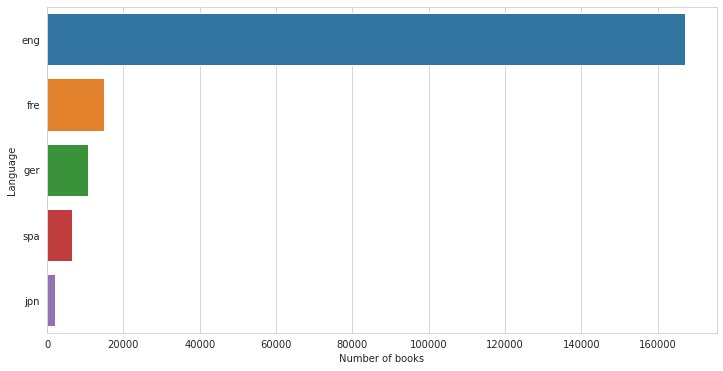

In [21]:
plt.figure(figsize=(12, 6))
langs = sns.barplot(
    x=books["Language"].value_counts().head(5),
    y=books["Language"].value_counts().head(5).index,
)
langs.set_xlabel("Number of books")
langs.set_ylabel("Language")

Most of the books are written in English, so we will leave only it for our recommendations for now.

In [22]:
books = books[books["Language"] == "eng"]
books.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167086 entries, 0 to 40883
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Id                     167086 non-null  int64  
 1   Name                   167086 non-null  object 
 2   pagesNumber            111272 non-null  float64
 3   RatingDistTotal        167086 non-null  int64  
 4   PublishDay             167086 non-null  int64  
 5   Publisher              164645 non-null  object 
 6   CountsOfReview         167086 non-null  int64  
 7   PublishYear            167086 non-null  int64  
 8   Language               167086 non-null  object 
 9   Authors                167086 non-null  object 
 10  Rating                 167086 non-null  float64
 11  RatingDist5            167086 non-null  int64  
 12  ISBN                   165651 non-null  object 
 13  Description            94818 non-null   object 
 14  Count of text reviews  44605 non-null

## pagesNumber, PagesNumber

Combine the values of two columns with the number of pages into one.

In [35]:
books["PageNumber"] = books[["pagesNumber", "PagesNumber"]].bfill(axis=1).iloc[:, 0]

In [37]:
books.drop(columns=["pagesNumber", "PagesNumber"], inplace=True)
books.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167086 entries, 0 to 40883
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Id                     167086 non-null  int64  
 1   Name                   167086 non-null  object 
 2   RatingDistTotal        167086 non-null  int64  
 3   PublishDay             167086 non-null  int64  
 4   Publisher              164645 non-null  object 
 5   CountsOfReview         167086 non-null  int64  
 6   PublishYear            167086 non-null  int64  
 7   Language               167086 non-null  object 
 8   Authors                167086 non-null  object 
 9   Rating                 167086 non-null  float64
 10  RatingDist5            167086 non-null  int64  
 11  ISBN                   165651 non-null  object 
 12  Description            94818 non-null   object 
 13  Count of text reviews  44605 non-null   float64
 14  PageNumber             167086 non-nul

## Description

Fill in the missing descriptions with book titles.

In [52]:
books.Description.fillna(books.Name, inplace=True)

We use a regular expression to clean up the descriptions, as some of them have embedded HTML tags.

In [75]:
CLEANR = re.compile("<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")


def cleanhtml(raw_html):
    cleantext = re.sub(CLEANR, "", raw_html)
    return cleantext

In [78]:
books["Description"] = books.Description.apply(cleanhtml)
books.Description.sample(100)

18837     The spell binding story of two lovers and two ...
2955                                              Gillespie
8166      This book recountsthe horror of World War II o...
52747                           Essential Daredevil, Vol. 3
6645               The Knight at Dawn (Great Reader Series)
                                ...                        
23406            Poppy Done to Death (Aurora Teagarden, #8)
83346     The Great War has ended And Gillian Maitland i...
160607    Fundamentals of Kayak Navigation is the author...
47847     This biography portrays the beautiful, enigmat...
6832      Armored Cav: A Guided Tour of an Armored Caval...
Name: Description, Length: 100, dtype: object

# Exploratory Data Analysis (EDA)

In [86]:
books.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167086 entries, 0 to 40883
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Id                     167086 non-null  int64  
 1   Name                   167086 non-null  object 
 2   RatingDistTotal        167086 non-null  int64  
 3   PublishDay             167086 non-null  int64  
 4   Publisher              164645 non-null  object 
 5   CountsOfReview         167086 non-null  int64  
 6   PublishYear            167086 non-null  int64  
 7   Language               167086 non-null  object 
 8   Authors                167086 non-null  object 
 9   Rating                 167086 non-null  float64
 10  RatingDist5            167086 non-null  int64  
 11  ISBN                   165651 non-null  object 
 12  Description            167086 non-null  object 
 13  Count of text reviews  44605 non-null   float64
 14  PageNumber             167086 non-nul

In [81]:
books_final = books[
    [
        "Id",
        "Name",
        "Authors",
        "ISBN",
        "PublishYear",
        "Language",
        "PageNumber",
        "Publisher",
        "CountsOfReview",
        "Rating",
        "RatingDist5",
        "RatingDistTotal",
    ]
]

In [82]:
books_final.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167086 entries, 0 to 40883
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Id               167086 non-null  int64  
 1   Name             167086 non-null  object 
 2   Authors          167086 non-null  object 
 3   ISBN             165651 non-null  object 
 4   PublishYear      167086 non-null  int64  
 5   Language         167086 non-null  object 
 6   PageNumber       167086 non-null  float64
 7   Publisher        164645 non-null  object 
 8   CountsOfReview   167086 non-null  int64  
 9   Rating           167086 non-null  float64
 10  RatingDist5      167086 non-null  int64  
 11  RatingDistTotal  167086 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 20.6+ MB


### Description of columns:
* Id - unique identifier for each book/series
* Name - title of the book
* Authors - the author of a particular book
* Rating - average rating of books determined by users
* ISBN - ISBN number(10)
* Language - the language in which the book is written
* PageNumber - number of pages in the book
* RatingDist5 - number of ratings marked 5
* RatingDistTotal - the number of ratings assigned to the book
* CountsOfReview - the number of reviews left by users

### What is the most popular book?

In [85]:
books_final[books_final["Rating"] == 5]

Id                                               Name  \
1669     2560                  Willem de Kooning: Late Paintings   
1847     2843  Literature Circle Guide: Bridge to Terabithia:...   
2715     4287  Middlesex Borough (Images of America: New Jersey)   
8946    14741  Zone of the Enders: The 2nd Runner Official St...   
10381   17224  The Diamond Color Meditation: Color Pathway to...   
...       ...                                                ...   
35689  987057                     Irish Republican Army Handbook   
36189  988348  Islam, Politics And The State: The Pakistan Ex...   
38258  993218  The Diaries Of Sir Robert Bruce Lockhart. Volu...   
39367  996239  Local and Global Analysis of Nonlinear Dispers...   
40386  998830                     The Day of the Lord Is at Hand   

                                    Authors        ISBN  PublishYear Language  \
1669                        Julie Sylvester  382960226X         2006      eng   
1847                         Tara MacCarthy  0439271711         2002      eng   
2715   Middlesex Borough Heritage Committee  0738511676         2003      eng   
8946                             Tim Bogenn  0744002354         2003      eng   
10381                         John  Diamond  1890995525         2006      eng   
...                                     ...         ...          ...      ...   
35689                 Irish Republican Army  0879475080         1981      eng   
36189                        M. Asghar Khan  0862324726         1986      eng   
38258                   R.H. Bruce Lockhart  0333151860         1973      eng   
39367                           Terence Tao  0821841432         2006      eng   
40386                       Benjamin Baruch  0976457490         2005      eng   

       PageNumber                         Publisher  CountsOfReview  Rating  \
1669         83.0                    Schirmer Mosel               0     5.0   
1847         32.0                Teaching Resources               1     5.0   
2715        128.0                Arcadia Publishing               0     5.0   
8946        128.0                        BradyGames               0     5.0   
10381        74.0             Square One Publishers               3     5.0   
...           ...                               ...             ...     ...   
35689        52.0               Desert Publications               1     5.0   
36189       304.0  Third World Books/Zed Books Ltd.               0     5.0   
38258       416.0                         Macmillan               0     5.0   
39367       373.0     American Mathematical Society               0     5.0   
40386       384.0        Get Ready Publishing, Inc.               1     5.0   

       RatingDist5  RatingDistTotal  
1669             1                1  
1847             4                4  
2715             2                2  
8946             2                2  
10381            5                5  
...            ...              ...  
35689            2                2  
36189            3                3  
38258            1                1  
39367            3                3  
40386            1                1  

[2475 rows x 12 columns]

In [87]:
books_final[
    (books_final["Rating"] > 4.5) & (books_final["RatingDistTotal"] > 1000)
].sort_values("Rating", ascending=False).head(3)

Id                                               Name  \
14698  24812                     The Complete Calvin and Hobbes   
6          8  Harry Potter Boxed Set, Books 1-5 (Harry Potte...   
55622  95602                           Mark of the Lion Trilogy   

               Authors        ISBN  PublishYear Language  PageNumber  \
14698   Bill Watterson  0740748475         2005      eng      1456.0   
6         J.K. Rowling  0439682584         2004      eng      2690.0   
55622  Francine Rivers  0842339523         1998      eng      1468.0   

                       Publisher  CountsOfReview  Rating  RatingDist5  \
14698  Andrews McMeel Publishing             940    4.82        29520   
6                     Scholastic             166    4.78        37432   
55622              Tyndale House             757    4.77         9168   

       RatingDistTotal  
14698            34079  
6                43968  
55622            11152

We see that the book with the best rating and more than 1000 reviews is The Complete Calvin and Hobbes by Bill Watterson.

Let's also see which books are in the top ten most rated.

<Axes: xlabel='RatingDistTotal', ylabel='Name'>

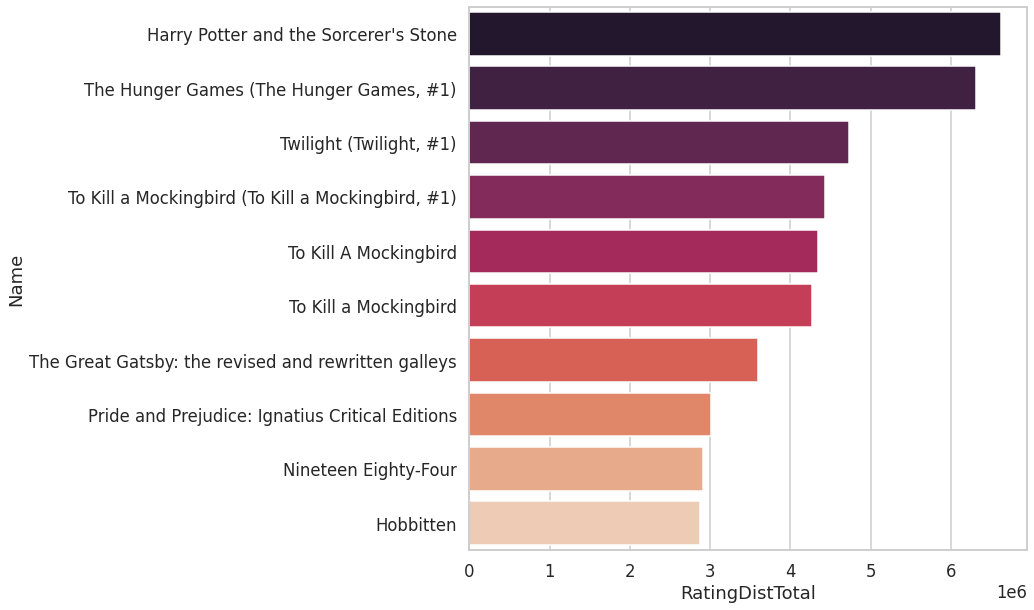

In [131]:
most_rated = (
    books_final.sort_values("RatingDistTotal", ascending=False)
    .head(10)
    .set_index("Name")
)
plt.figure(figsize=(10, 10))
sns.barplot(x=most_rated["RatingDistTotal"], y=most_rated.index, palette="rocket")

### Who is the most popular author?

In [88]:
books_final.groupby("Authors")["RatingDistTotal"].sum().sort_values(
    ascending=False
).head(5)

Authors
William Shakespeare    60253598
J.K. Rowling           44544303
J.R.R. Tolkien         43880971
C.S. Lewis             31697961
Jane Austen            14061961
Name: RatingDistTotal, dtype: int64

In [89]:
books_final.groupby("Authors")["RatingDist5"].sum().sort_values(ascending=False).head(5)

Authors
J.K. Rowling           29176145
J.R.R. Tolkien         23846552
William Shakespeare    19310784
C.S. Lewis             14152002
Jane Austen             7164179
Name: RatingDist5, dtype: int64

We see that the most popular English-language author is William Shakespeare, and the best author with more 5 ratings is JK Rowling.

Now let's see who is in the top ten most highly rated authors.

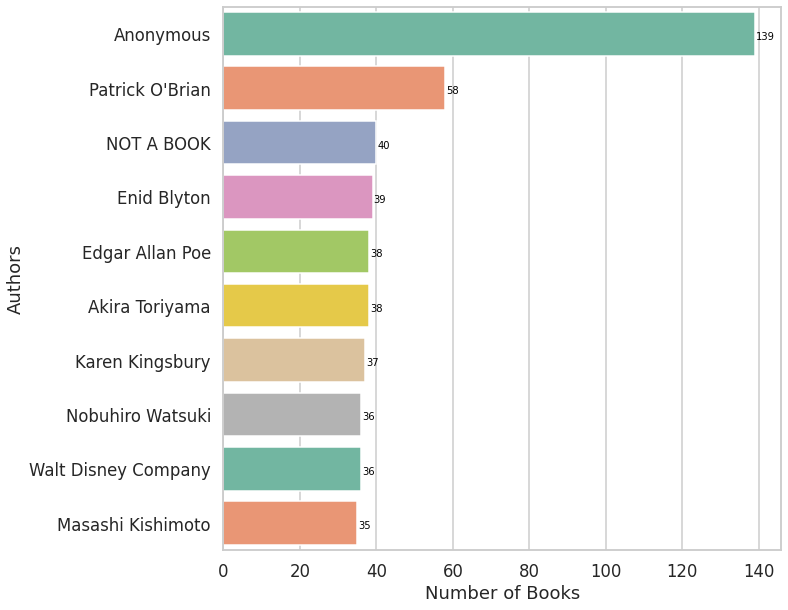

In [130]:
high_rated_author = books_final[books_final["Rating"] >= 4.3]
high_rated_author = (
    high_rated_author.groupby("Authors")["Name"]
    .count()
    .reset_index()
    .sort_values("Name", ascending=False)
    .head(10)
    .set_index("Authors")
)

plt.figure(figsize=(10, 10))
ax = sns.barplot(x=high_rated_author["Name"], y=high_rated_author.index, palette="Set2")
ax.set_xlabel("Number of Books")
ax.set_ylabel("Authors")
for i in ax.patches:
    ax.text(
        i.get_width() + 0.3,
        i.get_y() + 0.5,
        str(round(i.get_width())),
        fontsize=10,
        color="k",
    )

### Which author has written the most books?

In [90]:
books_final.groupby("Authors")["Name"].count().sort_values(ascending=False).head(10)

Authors
Francine Pascal        443
Anonymous              302
Enid Blyton            290
Ann M. Martin          287
Nora Roberts           261
R.L. Stine             222
Carolyn Keene          206
Agatha Christie        203
William Shakespeare    164
Isaac Asimov           154
Name: Name, dtype: int64

Francine Pascal turned out to be the most productive author, although this is rather strange.

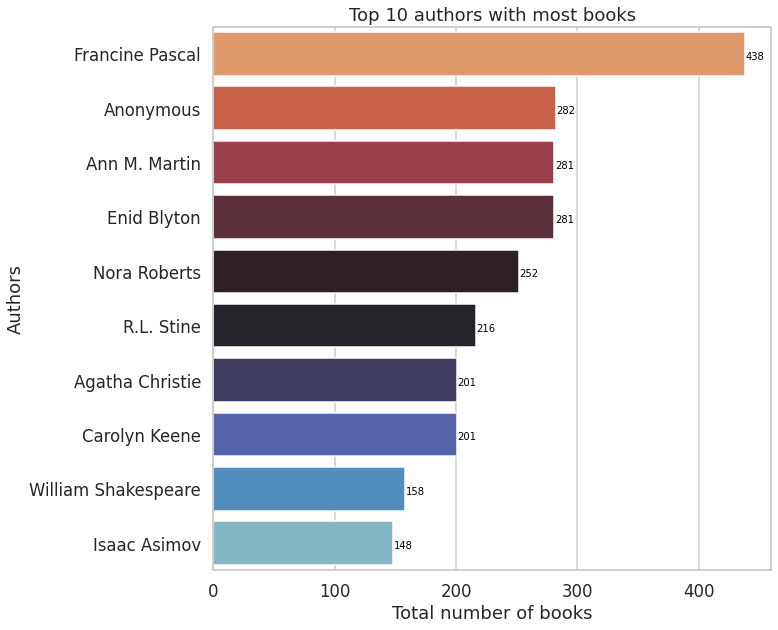

In [129]:
sns.set_context("talk")
most_books = (
    books_final.groupby("Authors")["Name"]
    .count()
    .reset_index()
    .sort_values("Name", ascending=False)
    .head(10)
    .set_index("Authors")
)

plt.figure(figsize=(10, 10))
ax = sns.barplot(x=most_books["Name"], y=most_books.index, palette="icefire_r")
ax.set_title("Top 10 authors with most books")
ax.set_xlabel("Total number of books")
for i in ax.patches:
    ax.text(
        i.get_width() + 0.3,
        i.get_y() + 0.5,
        str(round(i.get_width())),
        fontsize=10,
        color="k",
    )

### Correlations

Does page count correlate with rankings or reviews?

In [127]:
corr_columns = [
    "PageNumber",
    "Rating",
    "RatingDistTotal",
    "RatingDist5",
    "CountsOfReview",
]
corr_mat = books_final[corr_columns].corr()
corr_mat

PageNumber    Rating  RatingDistTotal  RatingDist5  \
PageNumber         1.000000  0.015913         0.009496     0.011134   
Rating             0.015913  1.000000         0.031934     0.033206   
RatingDistTotal    0.009496  0.031934         1.000000     0.967063   
RatingDist5        0.011134  0.033206         0.967063     1.000000   
CountsOfReview     0.012030  0.026992         0.423705     0.407070   

                 CountsOfReview  
PageNumber             0.012030  
Rating                 0.026992  
RatingDistTotal        0.423705  
RatingDist5            0.407070  
CountsOfReview         1.000000

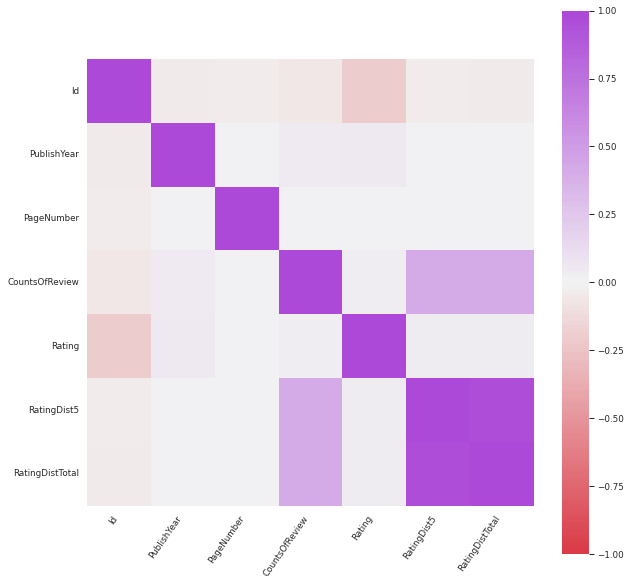

In [128]:
plt.figure(figsize=(10, 10))
corr = books_final.corr()
ax = sns.heatmap(
    corr,
    vmin=-1,
    vmax=1,
    center=0,
    cmap=sns.diverging_palette(10, 650, n=200),
    square=True,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=55, horizontalalignment="right")

We see that the number of reviews does not depend on the number of pages.

### In what year were the most books written?

Text(0, 0.5, 'Number of books')

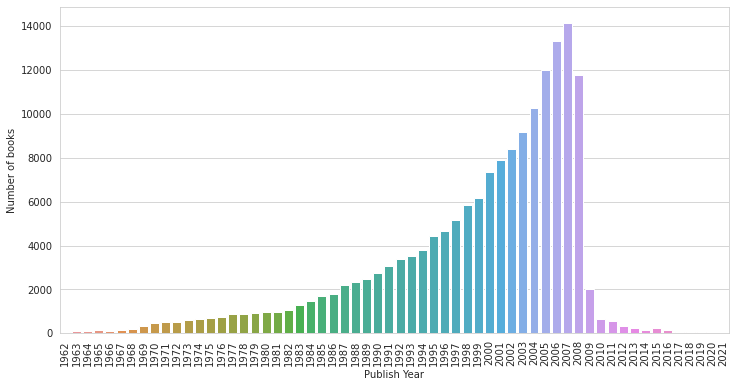

In [92]:
plt.figure(figsize=(12, 6))
books_years = sns.barplot(
    y=books_final.groupby(["PublishYear"])["Name"].count().tail(60),
    x=books_final.groupby(["PublishYear"])["Name"].count().tail(60).index,
)
books_years.set_xticklabels(books_years.get_xticklabels(), rotation=90)
books_years.set_xlabel("Publish Year")
books_years.set_ylabel("Number of books")

After 2007, we observe a decrease in the number of books written, perhaps due to incomplete data, or a trend towards a decrease in the amount of modern literature.

### Is there a trend towards reducing the number of pages in modern books?

In [94]:
books_final.groupby(["PublishYear"])["PageNumber"].mean().tail(10)

PublishYear
2012    272.198830
2013    268.742972
2014    264.389937
2015    215.877273
2016    258.895522
2017    262.369863
2018    289.311688
2019    272.689655
2020    331.846154
2021    357.500000
Name: PageNumber, dtype: float64

<Axes: xlabel='PublishYear', ylabel='PageNumber'>

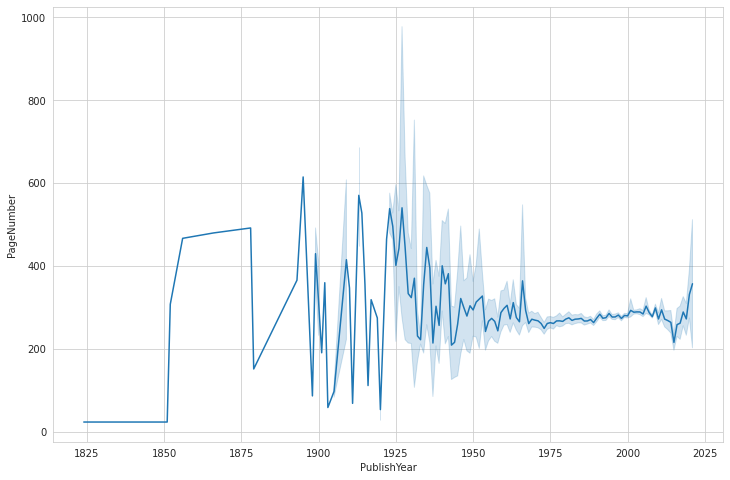

In [95]:
plt.figure(figsize=(12, 8))
sns.lineplot(x="PublishYear", y="PageNumber", data=books_final)

In general, one can notice a decrease in the number of pages by almost 2-3 times compared to the 20th century, the data for the first half of the 19th century is most likely incomplete.

### What is the distribution of book rankings?

In [112]:
books_final.Rating.isnull().value_counts()

False    167086
Name: Rating, dtype: int64

<ipython-input-117-2550fedf2905>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rating, bins=20)


<Axes: xlabel='Rating', ylabel='Density'>

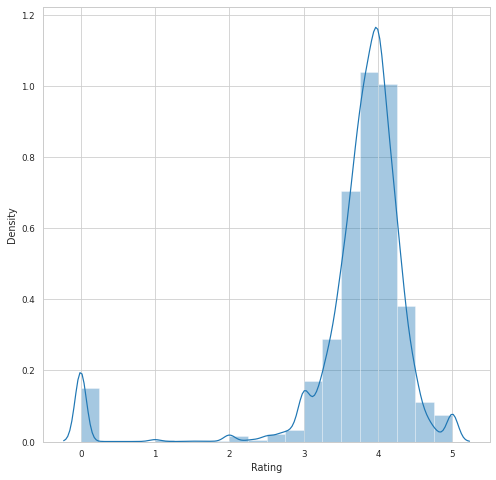

In [117]:
plt.figure(figsize=(8, 8))
rating = books_final.Rating.astype(float)
sns.distplot(rating, bins=20)

Most of the ratings are somewhere around 3.75 - 4.25, and books with a rating around 5 are rare.

In [132]:
books.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167086 entries, 0 to 40883
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Id                     167086 non-null  int64  
 1   Name                   167086 non-null  object 
 2   RatingDistTotal        167086 non-null  int64  
 3   PublishDay             167086 non-null  int64  
 4   Publisher              164645 non-null  object 
 5   CountsOfReview         167086 non-null  int64  
 6   PublishYear            167086 non-null  int64  
 7   Language               167086 non-null  object 
 8   Authors                167086 non-null  object 
 9   Rating                 167086 non-null  float64
 10  RatingDist5            167086 non-null  int64  
 11  ISBN                   165651 non-null  object 
 12  Description            167086 non-null  object 
 13  Count of text reviews  44605 non-null   float64
 14  PageNumber             167086 non-nul

In [135]:
books.to_csv(r'/content/drive/MyDrive/BooksRecSys/books_dataset.csv', index=False)